In [322]:
import os

import pandas as pd
import numpy as np

from utils.process import categorize

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Import dataset

In [323]:
# See working directory (No need, just for myself)
os.getcwd()

'/home/brendan/Documents/Jupyter/projet_data'

In [324]:
df = pd.read_csv('./data_cars.csv')

In [325]:
df.head(10)

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description
0,11220.0,PEUGEOT,308,2014,94341.0 km,Diesel,mécanique,06/07/2018 à 3h47,"modele: 308 (2E GENERATION), version: 1.6 HDI ..."
1,57526.0,BMW,X6,2015,39051.0 km,Diesel,automatique,03/04/2018 à 16h41,"modele: X6 F16, version: (F16) XDRIVE30D 258 M..."
2,80379.0,AUDI,RS6,2014,75381.0 km,Essence,automatique,30/07/2018 à 1h55,"modele: RS6 (3E GENERATION) AVANT, version: II..."
3,2830.0,FORD,KA,2007,92282.0 km,Essence,mécanique,09/07/2018 à 14h12,"modele: KA, version: 1.3 70 FUN, puissance_fis..."
4,12925.0,FIAT,TIPO,2018,10.0 km,Essence,mécanique,19/05/2018 à 3h52,"modele: TIPO 2 SW, version: II SW 1.4 95 POP, ..."
5,27956.0,BMW,X3,2012,95623.0 km,Diesel,automatique,14/03/2018 à 4h24,"modele: X3 F25, version: (F25) XDRIVE35D 313 S..."
6,16888.0,AUDI,A3,2013,49018.0 km,Diesel,mécanique,16/04/2018 à 21h35,"modele: A3 (2E GENERATION) SPORTBACK, version:..."
7,18188.0,RENAULT,MEGANE,2017,9795.0 km,Diesel,automatique,29/04/2018 à 12h44,"modele: MEGANE 4 ESTATE, version: IV ESTATE 1...."
8,10594.0,FORD,C-MAX,2012,126670.0 km,Diesel,mécanique,22/06/2018 à 5h11,"modele: C-MAX 2, version: II 1.6 TDCI 115 FAP ..."
9,69131.0,MERCEDES,CLASSE C,2015,39439.0 km,Essence,automatique,08/03/2018 à 17h35,"modele: CLASSE C 4 AMG, version: (W205) 63 AMG..."


## Observations

In [326]:
import matplotlib.pyplot as plt

%matplotlib inline

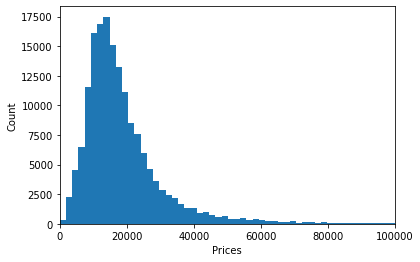

In [327]:
# Price repartition
plt.hist(df["Price"], 800)
plt.xlim(0, 100000)
plt.xlabel('Prices')
plt.ylabel('Count')
plt.show()

Les prix semblent s'agglutiner entre 20000 et 25000 €

<BarContainer object of 20 artists>

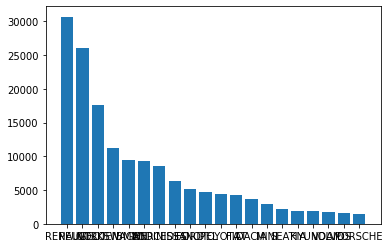

In [354]:
# Make cars counts
counts = df["Make"].value_counts().iloc[0:20]
names = counts.keys().to_numpy()
values = counts.to_numpy()

fig, axs = plt.subplots(1, 1)
axs.bar(names, values)

## Some data cleaning

### Data checks

In [300]:
# Check for null values
df.isnull().sum()

Price          0
Make           0
Model          0
Model_year     0
Mileage        0
Fuel           0
Gearbox        0
Online         0
Description    0
dtype: int64

In [301]:
# Check for invalid numbers
df.isna().sum()

Price          0
Make           0
Model          0
Model_year     0
Mileage        0
Fuel           0
Gearbox        0
Online         0
Description    0
dtype: int64

In [302]:
# Find empty strings
np.where(df.applymap(lambda x: x == ''))

(array([], dtype=int64), array([], dtype=int64))

### Data types conversions

In [303]:
## Remove kilometers and convert to number
df["Mileage"] = df["Mileage"].str.replace(' km', '').astype("float64")
df.head(5)

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description
0,11220.0,PEUGEOT,308,2014,94341.0,Diesel,mécanique,06/07/2018 à 3h47,"modele: 308 (2E GENERATION), version: 1.6 HDI ..."
1,57526.0,BMW,X6,2015,39051.0,Diesel,automatique,03/04/2018 à 16h41,"modele: X6 F16, version: (F16) XDRIVE30D 258 M..."
2,80379.0,AUDI,RS6,2014,75381.0,Essence,automatique,30/07/2018 à 1h55,"modele: RS6 (3E GENERATION) AVANT, version: II..."
3,2830.0,FORD,KA,2007,92282.0,Essence,mécanique,09/07/2018 à 14h12,"modele: KA, version: 1.3 70 FUN, puissance_fis..."
4,12925.0,FIAT,TIPO,2018,10.0,Essence,mécanique,19/05/2018 à 3h52,"modele: TIPO 2 SW, version: II SW 1.4 95 POP, ..."


In [304]:
df.dtypes['Mileage']

dtype('float64')

In [305]:
df["Mileage"].isna().sum()

0

In [306]:
# Reduce allocated bytes size for "Model_year" 
df["Model_year"] = df["Model_year"].astype("int16")

In [307]:
# We don't really need the "Online" column as it seems to indicate the last user authentication
# df = df.drop("Online", axis=1)

### Hot encoding

In [308]:
# List categorical columns
df["Fuel"].unique()

array(['Diesel', 'Essence', 'Hybride essence électrique', 'Electrique',
       'Bicarburation essence GNV', 'Hybride diesel électrique',
       'Bicarburation essence GPL', 'Bicarburation essence bioéthanol'],
      dtype=object)

In [309]:
# List categorical columns for Gearbox
df["Gearbox"].unique()

array(['mécanique', 'automatique'], dtype=object)

In [310]:
df = pd.get_dummies(df, columns=["Gearbox"], drop_first=True)

In [311]:
# List categorical columns
df = pd.get_dummies(df, columns=["Fuel"])

In [312]:
df.head(5)

,Price,Make,Model,Model_year,Mileage,Online,Description,Gearbox_mécanique,Fuel_Bicarburation essence GNV,Fuel_Bicarburation essence GPL,Fuel_Bicarburation essence bioéthanol,Fuel_Diesel,Fuel_Electrique,Fuel_Essence,Fuel_Hybride diesel électrique,Fuel_Hybride essence électrique
0,11220.0,PEUGEOT,308,2014,94341.0,06/07/2018 à 3h47,"modele: 308 (2E GENERATION), version: 1.6 HDI ...",1,0,0,0,1,0,0,0,0
1,57526.0,BMW,X6,2015,39051.0,03/04/2018 à 16h41,"modele: X6 F16, version: (F16) XDRIVE30D 258 M...",0,0,0,0,1,0,0,0,0
2,80379.0,AUDI,RS6,2014,75381.0,30/07/2018 à 1h55,"modele: RS6 (3E GENERATION) AVANT, version: II...",0,0,0,0,0,0,1,0,0
3,2830.0,FORD,KA,2007,92282.0,09/07/2018 à 14h12,"modele: KA, version: 1.3 70 FUN, puissance_fis...",1,0,0,0,0,0,1,0,0
4,12925.0,FIAT,TIPO,2018,10.0,19/05/2018 à 3h52,"modele: TIPO 2 SW, version: II SW 1.4 95 POP, ...",1,0,0,0,0,0,1,0,0


In [313]:
np.sort(df['Make'].unique())

array(['ABARTH', 'AC', 'AIXAM', 'ALFA ROMEO', 'ALPINA', 'ALPINE',
       'ASTON MARTIN', 'AUDI', 'AUSTIN', 'AUSTIN HEALEY', 'AUTOBIANCHI',
       'BELLIER', 'BENTLEY', 'BMW', 'BMW-ALPINA', 'BOLLORE', 'BUGATTI',
       'BURBY S', 'CADILLAC', 'CATERHAM', 'CHATENET', 'CHEVROLET',
       'CHRYSLER', 'CITROEN', 'DACIA', 'DAEWOO', 'DAIHATSU', 'DANGEL',
       'DODGE', 'DONKERVOORT', 'DS', 'FERRARI', 'FIAT', 'FISKER', 'FORD',
       'GRECAV', 'HONDA', 'HUMMER', 'HYUNDAI', 'INFINITI', 'INNOCENTI',
       'INTERMECCANICA', 'JAGUAR', 'JEEP', 'JIAYUAN', 'KIA', 'LADA',
       'LAMBORGHINI', 'LANCIA', 'LAND ROVER', 'LEXUS', 'LIGIER', 'LOTUS',
       'MASERATI', 'MATRA', 'MAZDA', 'MCLAREN', 'MERCEDES',
       'MERCEDES-AMG', 'MG', 'MIA ELECTRIC', 'MICROCAR', 'MINI',
       'MITSUBISHI', 'MORGAN', 'MPM MOTORS', 'NISSAN', 'OLDSMOBILE',
       'OPEL', 'PACKARD', 'PEUGEOT', 'PORSCHE', 'RENAULT', 'RILEY',
       'ROLLS ROYCE', 'ROVER', 'SAAB', 'SEAT', 'SECMA', 'SHELBY', 'SIMCA',
       'SKODA', 'SMART', 

In [314]:
df['Make'] = categorize(df['Make'])
df['Make'].head(20)

0      0
1      1
2      2
3      3
4      4
5      1
6      2
7      5
8      3
9      6
10     7
11     8
12     4
13     3
14     9
15    10
16     0
17    11
18    12
19    13
Name: Make, dtype: int8

In [315]:
np.sort(df['Model'].unique())

array(['1000', '1007', '106', '107', '108', '1200', '121', '124', '126',
       '130', '1300', '145', '146', '147', '156', '159', '160', '166',
       '170', '180', '190', '2', '2 ELEVEN', '200', '2002', '2008', '205',
       '206', '206+', '207', '207+', '208', '230', '25', '250', '2600',
       '280', '2CV', '3', '3.0', '300', '300 C', '3000', '3008', '306',
       '307', '308', '309', '3200 GT', '33', '330', '348', '350Z', '356',
       '360', '365', '370Z', '4/4', '400', '4007', '4008', '403', '404',
       '406', '407', '420', '45', '450', '456', '458', '488', '4C', '5',
       '500', '500 L', '500 X', '5008', '504', '505', '508', '508 RXH',
       '512', '550', '560', '570S', '575', '599', '6', '604', '607',
       '612', '626', '650 S', '675 LT', '718', '720S', '75',
       '75 LIMOUSINE BVA', '80', '806', '807', '812', '812 SUPERFAST',
       '9-3', '9-5', '911', '924', '928', '944', '99', 'A', 'A1', 'A112',
       'A2', 'A3', 'A4', 'A4 ALLROAD', 'A5', 'A6', 'A6 ALLROAD', 'A610

In [316]:
df['Model'] = categorize(df['Model'])
df.head(20)

,Price,Make,Model,Model_year,Mileage,Online,Description,Gearbox_mécanique,Fuel_Bicarburation essence GNV,Fuel_Bicarburation essence GPL,Fuel_Bicarburation essence bioéthanol,Fuel_Diesel,Fuel_Electrique,Fuel_Essence,Fuel_Hybride diesel électrique,Fuel_Hybride essence électrique
0,11220.0,0,0,2014,94341.0,06/07/2018 à 3h47,"modele: 308 (2E GENERATION), version: 1.6 HDI ...",1,0,0,0,1,0,0,0,0
1,57526.0,1,1,2015,39051.0,03/04/2018 à 16h41,"modele: X6 F16, version: (F16) XDRIVE30D 258 M...",0,0,0,0,1,0,0,0,0
2,80379.0,2,2,2014,75381.0,30/07/2018 à 1h55,"modele: RS6 (3E GENERATION) AVANT, version: II...",0,0,0,0,0,0,1,0,0
3,2830.0,3,3,2007,92282.0,09/07/2018 à 14h12,"modele: KA, version: 1.3 70 FUN, puissance_fis...",1,0,0,0,0,0,1,0,0
4,12925.0,4,4,2018,10.0,19/05/2018 à 3h52,"modele: TIPO 2 SW, version: II SW 1.4 95 POP, ...",1,0,0,0,0,0,1,0,0
5,27956.0,1,5,2012,95623.0,14/03/2018 à 4h24,"modele: X3 F25, version: (F25) XDRIVE35D 313 S...",0,0,0,0,1,0,0,0,0
6,16888.0,2,6,2013,49018.0,16/04/2018 à 21h35,"modele: A3 (2E GENERATION) SPORTBACK, version:...",1,0,0,0,1,0,0,0,0
7,18188.0,5,7,2017,9795.0,29/04/2018 à 12h44,"modele: MEGANE 4 ESTATE, version: IV ESTATE 1....",0,0,0,0,1,0,0,0,0
8,10594.0,3,8,2012,126670.0,22/06/2018 à 5h11,"modele: C-MAX 2, version: II 1.6 TDCI 115 FAP ...",1,0,0,0,1,0,0,0,0
9,69131.0,6,9,2015,39439.0,08/03/2018 à 17h35,"modele: CLASSE C 4 AMG, version: (W205) 63 AMG...",0,0,0,0,0,0,1,0,0


In [317]:
df.dtypes

Price                                    float64
Make                                        int8
Model                                      int16
Model_year                                 int16
Mileage                                  float64
Online                                    object
Description                               object
Gearbox_mécanique                          uint8
Fuel_Bicarburation essence GNV             uint8
Fuel_Bicarburation essence GPL             uint8
Fuel_Bicarburation essence bioéthanol      uint8
Fuel_Diesel                                uint8
Fuel_Electrique                            uint8
Fuel_Essence                               uint8
Fuel_Hybride diesel électrique             uint8
Fuel_Hybride essence électrique            uint8
dtype: object

## Split

In [318]:
features = [
    "Make", 
    "Model", 
    "Model_year", 
    "Gearbox_mécanique",
    "Fuel_Bicarburation essence GNV",
    "Fuel_Bicarburation essence GPL",
    "Fuel_Bicarburation essence bioéthanol",
    "Fuel_Diesel",
    "Fuel_Electrique",
    "Fuel_Essence"
]

prediction = "Price"

X = df[features]
y = df[prediction]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [319]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((116686, 10), (50009, 10), (116686,), (50009,))

In [320]:
X_train.head(5)

,Make,Model,Model_year,Gearbox_mécanique,Fuel_Bicarburation essence GNV,Fuel_Bicarburation essence GPL,Fuel_Bicarburation essence bioéthanol,Fuel_Diesel,Fuel_Electrique,Fuel_Essence
26473,12,55,2018,0,0,0,0,1,0,0
20079,8,11,2017,0,0,0,0,0,0,1
34789,11,21,2017,0,0,0,0,0,0,1
60478,28,127,2018,1,0,0,0,1,0,0
77881,13,19,2015,1,0,0,0,1,0,0


In [321]:
y_train.head(5)

26473    24123.0
20079    25026.0
34789    15351.0
60478    27723.0
77881    16141.0
Name: Price, dtype: float64

## Train